### STOR 566 Homework 2 Submission 

Downloading data:

In [1]:
batch_size = 200
data_dir = '/home/clewis7/repos/stor566-notebooks/hmw2/hmw2-data/'

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torch.utils.data as td
import random, time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

## USE THIS SNIPPET TO GET BINARY TRAIN/TEST DATA

train_data = datasets.MNIST(data_dir, train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
# Once you have downloaded the data by setting download=True, you can
# change download=True to download=False
test_data = datasets.MNIST(data_dir, train=False, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

subset_indices = ((train_data.targets == 0) + (train_data.targets == 1)).nonzero()
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size, 
  shuffle=False,sampler=SubsetRandomSampler(subset_indices.view(-1)))

subset_indices = ((test_data.targets == 0) + (test_data.targets == 1)).nonzero()
test_loader = torch.utils.data.DataLoader(test_data,batch_size=len(test_data), 
  shuffle=False,sampler=SubsetRandomSampler(subset_indices.view(-1)))

### 1. (20 points) Implement **Logistic Regression** with Pytorch to do handwritten digit 0 vs. 1 classification. Pick an optimizer yourself. 

In [4]:
class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
         self.linear.weight.data.fill_(1)
            
     def forward(self, x):
         out = torch.sigmoid(self.linear(x))
         return out

In [5]:
input_dim = 28*28
output_dim = 1
model = LogisticRegression(input_dim,output_dim)

In [6]:
criterion = torch.nn.BCELoss()

In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

In [3]:
from tqdm import tqdm

epochs = iterations / (total data / batch size)

In [9]:
# The number of epochs is at least 10, you can increase it to achieve better performance
num_epochs = 25

avg_losses = list()

# Training the Model
for epoch in tqdm(range(num_epochs)):
    batch_losses = list()
    for i, (images, labels) in enumerate(train_loader):
        # Convert the 28*28 image matrix into a 784-dim vector
        images = images.view(-1, 28*28).requires_grad_()
        labels = labels
        # Convert labels from 0,1 to -1,1
        #labels = 2*(labels.float()-0.5)
        
        # TODO 
        # 1. Compute Loss. Check torch functions for the corresponding loss for Logistic and SVM
        optimizer.zero_grad()
    
        prediction = model.forward(images)
        
        batch_loss = criterion(prediction, labels.reshape(-1,1).to(torch.float32))
        
        batch_loss.backward()
        
        # 2. Do optimization. Check torch.optim to see how to do optimization with pytorch
        optimizer.step()
    
        # 3. Save batch loss
        batch_losses.append(batch_loss.detach().numpy())

    # Save average epoch loss
    avg_epoch_loss = (1 / batch_size) * np.sum(batch_losses)
    avg_losses.append(avg_epoch_loss)
    
    
    

100%|███████████████████████████████████████████| 25/25 [00:24<00:00,  1.01it/s]


### (a) (5 points) Report the hyper-parameters (number of epochs, learning rate, momentum etc).

**Hyper-Parameters**

Number of Epochs: 25

Learning Rate: 0.01

Momentum: 0.9

### (b) (10 points) Report the **Average loss of an epoch** for every epoch by generating Average Loss vs. Epoch plot. Please report at least **10** epochs.

In [11]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Average Loss')

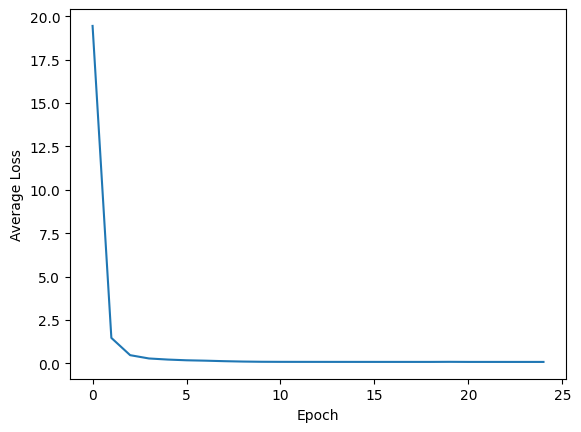

In [12]:
plt.plot(avg_losses)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")

### (c) (5 points) Report the final testing accuracy of trained model.

In [13]:
correct = 0

images, labels = next(iter(test_loader))

outputs = model.forward(images.view(-1, 28*28))
outputs = outputs.detach().numpy().astype(int).ravel()

labels = labels.detach().numpy().astype(int)

for output, label in zip(outputs, labels):
    if output == label:
        correct += 1

accuracy = correct / len(labels)

In [14]:
accuracy

0.9985815602836879

### 2. (20 points) Implement **Linear SVM** with Pytorch to do handwritten digit 0 vs. 1 classification. Pick an optimizer yourself. 

### (a) (5 points) Report the hyper-parameters (number of epochs, learning rate, momentum etc).

**Hyper-Parameters**

Number of Epochs: 25

Learning Rate: 0.05

Momentum: 0.9

In [18]:
class LinearSVM(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearSVM, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x).clamp(-1,1)
        return out

In [19]:
def hinge_loss(weights, prediction, actual):
    
    x = torch.max(torch.zeros(prediction.ravel().size()[0]),
                  (1 - actual.ravel() * prediction.ravel())).mean()
    return x

In [20]:
input_dim = 28*28
output_dim = 1
model = LinearSVM(input_dim,output_dim)

In [21]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

In [22]:
loss_func = hinge_loss

In [23]:
# The number of epochs is at least 10, you can increase it to achieve better performance
num_epochs = 25

avg_losses = list()

# Training the Model
for epoch in tqdm(range(num_epochs)):
    batch_losses = list()
    for i, (images, labels) in enumerate(train_loader):
        # Convert the 28*28 image matrix into a 784-dim vector
        images = images.view(-1, 28*28)
        # Convert labels from 0,1 to -1,1
        labels = 2*(labels.float()-0.5)
        
        # TODO 
        # 1. Compute Loss. Check torch functions for the corresponding loss for Logistic and SVM
        optimizer.zero_grad()
    
        prediction = model.forward(images)
        weights = list(model.parameters())[0].data
        
        batch_loss = loss_func(weights, prediction, labels.reshape(-1,1).to(torch.float32))
        
        batch_loss.backward()
        
        # 2. Do optimization. Check torch.optim to see how to do optimization with pytorch
        optimizer.step()
    
        # 3. Save batch loss
        batch_losses.append(batch_loss.detach().numpy())

    # Save average epoch loss
    avg_epoch_loss = (1 / batch_size) * np.sum(batch_losses)
    avg_losses.append(avg_epoch_loss)

100%|███████████████████████████████████████████| 25/25 [00:24<00:00,  1.01it/s]


### (b) (10 points) Report the **Average loss of an epoch** for every epoch by generating Average Loss vs. Epoch plot. Please report at least **10** epochs.

Text(0, 0.5, 'Average Loss')

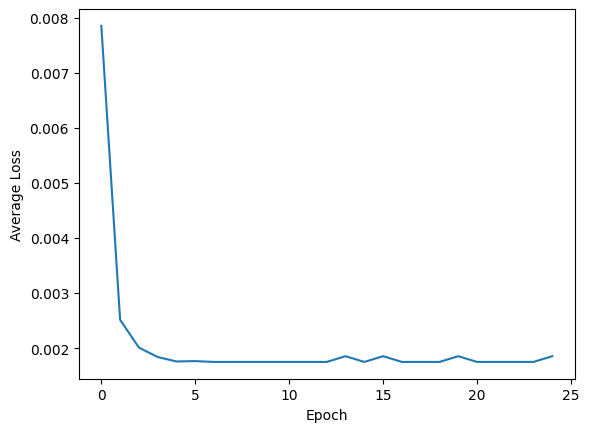

In [24]:
plt.plot(avg_losses)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")

### (c) (5 points) Report the final testing accuracy of trained model.

In [25]:
correct = 0

images, labels = next(iter(test_loader))

outputs = model.forward(images.view(-1, 28*28))
outputs = outputs.detach().numpy().astype(int).ravel()

outputs[outputs < 0] = 0

labels = labels.reshape(-1,1).to(torch.float32)
labels = labels.detach().numpy().astype(int)

for output, label in zip(outputs, labels):
    if output == label:
        correct += 1

accuracy = correct / len(labels)

In [26]:
accuracy

0.9981087470449173

## Problem 2 (60 points)

In this problem you will practice implementing MLP and CNN to classify daily life images (CIFAR10).

**Data.** You will use CIFAR10 classification dataset (10 classes). Pytorch/torchvision has provide a useful dataloader to automatically download and load the data into batches. Code of the data loader has been provided in the template. Please don't modify the data loading part.

In [2]:
## Data loading code chunk, please don't modify it. 
## However, you can adjust the batch size if you want to.
batch_size_cifar = 128
data_dir = './data'

def cifar_loaders(batch_size, shuffle_test=False): 
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.225, 0.225, 0.225])
    train = datasets.CIFAR10(data_dir, train=True, download=False, 
        transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]))
    # Once you have downloaded the data by setting download=True, you can
    # change download=True to download=False
    test = datasets.CIFAR10(data_dir, train=False, 
        transform=transforms.Compose([transforms.ToTensor(), normalize]))
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
        shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=len(test_data),
        shuffle=shuffle_test, pin_memory=True)
    return train_loader, test_loader

train_loader, test_loader = cifar_loaders(batch_size_cifar)

### **Problem Description.**
### 1. (20 points) Implement a 7 layers fully-connected neural networks with ReLU activation to do image classification. 

In [4]:
cuda = torch.device("cuda")
torch.cuda.device(0)

In [31]:
class NeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetModel, self).__init__() 
        self.feature = nn.Sequential(
            nn.Linear(hidden_dim, 3072),  
            nn.ReLU(),
            nn.Linear(hidden_dim, 4096),  
            nn.ReLU(),
            nn.Linear(4096, 4096),  
            nn.ReLU(),
            nn.Linear(4096, 4096),  
            nn.ReLU(),
            nn.Linear(4096, 4096),  
            nn.ReLU(),
            nn.Linear(4096, 4096),  
            nn.ReLU(),
            nn.Linear(4096, 10),  
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.feature(x)
        out = x
        return(out)

In [32]:
input_dim = 3 * 32*32
hidden_dim = 3 * 32*32
output_dim = 10
model = NeuralNetModel(input_dim, hidden_dim, output_dim).cuda()

In [33]:
criterion = nn.CrossEntropyLoss()

In [34]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [35]:
with torch.cuda.device(0):
    num_epochs = 30

    avg_losses = list()

    # Training the Model
    for epoch in tqdm(range(num_epochs)):
        batch_losses = list()
        for i, (images, labels) in enumerate(train_loader):
            images = images.view(-1, 3 * 32*32).requires_grad_()
            labels = labels

            # TODO 
            # 1. Compute Loss. 
            optimizer.zero_grad()

            prediction = model.forward(images.cuda())

            batch_loss = criterion(prediction, labels.cuda())

            batch_loss.backward()

            # 2. Do optimization. Check torch.optim to see how to do optimization with pytorch
            optimizer.step()

            # 3. Save batch loss
            batch_losses.append(batch_loss.detach().cpu().numpy())

        # Save average epoch loss
        avg_epoch_loss = (1 / batch_size) * np.sum(batch_losses)
        avg_losses.append(avg_epoch_loss)

 27%|███████████▋                                | 8/30 [01:35<04:23, 11.97s/it]


KeyboardInterrupt: 

### (a) (5 points) Print the model architecture.

In [77]:
model

NeuralNetModel(
  (feature): Sequential(
    (0): Linear(in_features=3072, out_features=3072, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=3072, out_features=4096, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=4096, out_features=4096, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=4096, out_features=4096, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=4096, out_features=4096, bias=True)
    (9): ReLU(inplace=True)
    (10): Linear(in_features=4096, out_features=4096, bias=True)
    (11): ReLU(inplace=True)
    (12): Linear(in_features=4096, out_features=10, bias=True)
    (13): ReLU(inplace=True)
  )
)

### (b) (10 points) Report the **Average loss of an epoch** for every epoch by generating Average Loss vs. Epoch plot. Please report at least **10** epochs.

Text(0, 0.5, 'Average Loss')

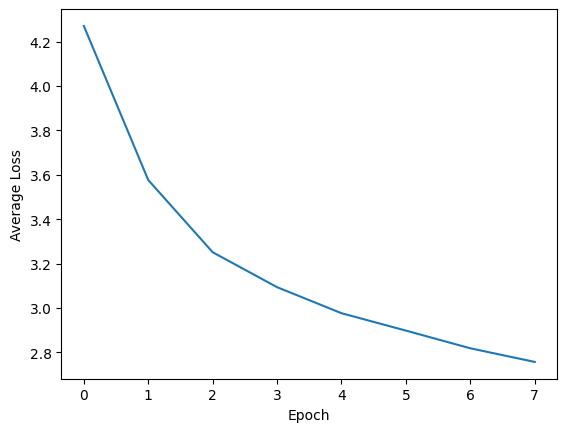

In [36]:
plt.plot(avg_losses)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")

### (c) (5 points) Report the final testing accuracy of trained model.

In [53]:
with torch.cuda.device(0):
    correct = 0

    images, labels = next(iter(test_loader))

    outputs = F.log_softmax(model.forward(images.cuda().view(-1, 3*32*32)), dim=1).argmax(dim=1)
    outputs = outputs.detach().cpu().numpy().astype(int).ravel()

    labels = labels.detach().cpu().numpy().astype(int)

    for output, label in zip(outputs, labels):
        if output == label:
            correct += 1

    accuracy = correct / len(labels)
accuracy

0.5014

### 2. (30 points) Implement a 7 layers CNN with 4 convolutional layers, 3 fully-connected layers and ReLU activation function. The input dimension of the 1st fully-connected layer must be 4096.

In [4]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__() 
        self.feature = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 1024, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(4096, 4096),  
            nn.ReLU(),
            nn.Linear(4096, 4096),  
            nn.ReLU(),
            nn.Linear(4096, 10),  
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.feature(x)
        out = x
        return(out)

In [5]:
input_dim = 3 * 32*32
hidden_dim = 3 * 32*32
output_dim = 10
model = CNNModel().cuda()

In [6]:
criterion = nn.CrossEntropyLoss()

In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [8]:
with torch.cuda.device(0):
    num_epochs = 30

    avg_losses = list()

    # Training the Model
    for epoch in tqdm(range(num_epochs)):
        batch_losses = list()
        for i, (images, labels) in enumerate(train_loader):
            # Convert the 28*28 image matrix into a 784-dim vector
            images = images.requires_grad_()
            labels = labels
            # Convert labels from 0,1 to -1,1
            #labels = 2*(labels.float()-0.5)

            # TODO 
            # 1. Compute Loss. Check torch functions for the corresponding loss for Logistic and SVM
            optimizer.zero_grad()

            prediction = model.forward(images.cuda())

            batch_loss = criterion(prediction, labels.cuda())

            batch_loss.backward()

            # 2. Do optimization. Check torch.optim to see how to do optimization with pytorch
            optimizer.step()

            # 3. Save batch loss
            batch_losses.append(batch_loss.detach().cpu().numpy())

        # Save average epoch loss
        avg_epoch_loss = (1 / batch_size) * np.sum(batch_losses)
        avg_losses.append(avg_epoch_loss)

100%|███████████████████████████████████████████| 30/30 [05:52<00:00, 11.74s/it]


### (a) (5 points) Print the model architecture.

In [13]:
model

CNNModel(
  (feature): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 1024, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=4096, out_features=4096, bias=True)
    (10): ReLU()
    (11): Linear(in_features=4096, out_features=4096, bias=True)
    (12): ReLU()
    (13): Linear(in_features=4096, out_features=10, bias=True)
    (14): ReLU()
  )
)

### (b) (10 points) Report the **Average loss of an epoch** for every epoch by generating Average Loss vs. Epoch plot. Please report at least **10** epochs.

Text(0, 0.5, 'Average Loss')

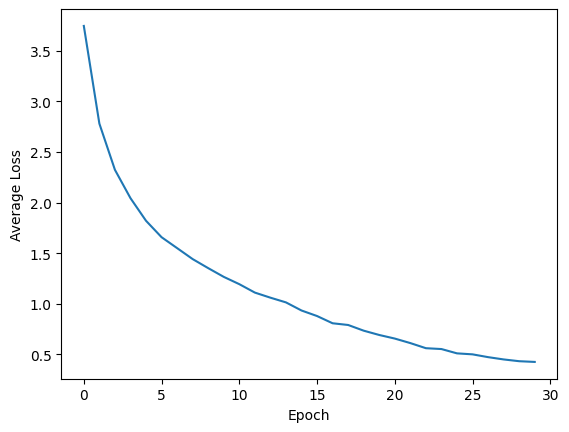

In [11]:
plt.plot(avg_losses)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")

### (c) (5 points) Report the final testing accuracy of trained model.

In [12]:
with torch.cuda.device(0):
    correct = 0

    images, labels = next(iter(test_loader))

    outputs = F.log_softmax(model.forward(images.cuda()), dim=1).argmax(dim=1)
    outputs = outputs.detach().cpu().numpy().astype(int).ravel()

    labels = labels.detach().cpu().numpy().astype(int)

    for output, label in zip(outputs, labels):
        if output == label:
            correct += 1

    accuracy = correct / len(labels)
accuracy

RuntimeError: CUDA out of memory. Tried to allocate 626.00 MiB (GPU 0; 23.70 GiB total capacity; 3.11 GiB already allocated; 16.75 MiB free; 3.16 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### (d) (10 points) Write a new cifar$\_$loaders function to try different data augmentation methods.

In [14]:
def cifar_loaders(batch_size, shuffle_test=False): 
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.225, 0.225, 0.225])
    train = datasets.CIFAR10(data_dir, train=True, download=False, 
        transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.Grayscale(3),
            transforms.ToTensor(),
            normalize,
        ]))
    # Once you have downloaded the data by setting download=True, you can
    # change download=True to download=False
    test = datasets.CIFAR10(data_dir, train=False, 
        transform=transforms.Compose([transforms.ToTensor(), normalize]))
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
        shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=len(test_data),
        shuffle=shuffle_test, pin_memory=True)
    return train_loader, test_loader

train_loader, test_loader = cifar_loaders(batch_size_cifar)

In [15]:
with torch.cuda.device(0):
    num_epochs = 30

    avg_losses = list()

    # Training the Model
    for epoch in tqdm(range(num_epochs)):
        batch_losses = list()
        for i, (images, labels) in enumerate(train_loader):
            # Convert the 28*28 image matrix into a 784-dim vector
            images = images.requires_grad_()
            labels = labels
            # Convert labels from 0,1 to -1,1
            #labels = 2*(labels.float()-0.5)

            # TODO 
            # 1. Compute Loss. Check torch functions for the corresponding loss for Logistic and SVM
            optimizer.zero_grad()

            prediction = model.forward(images.cuda())

            batch_loss = criterion(prediction, labels.cuda())

            batch_loss.backward()

            # 2. Do optimization. Check torch.optim to see how to do optimization with pytorch
            optimizer.step()

            # 3. Save batch loss
            batch_losses.append(batch_loss.detach().cpu().numpy())

        # Save average epoch loss
        avg_epoch_loss = (1 / batch_size) * np.sum(batch_losses)
        avg_losses.append(avg_epoch_loss)

  0%|                                                    | 0/30 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 23.70 GiB total capacity; 3.15 GiB already allocated; 16.75 MiB free; 3.16 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [12]:
with torch.cuda.device(0):
    correct = 0

    images, labels = next(iter(test_loader))

    outputs = F.log_softmax(model.forward(images.cuda()), dim=1).argmax(dim=1)
    outputs = outputs.detach().cpu().numpy().astype(int).ravel()

    labels = labels.detach().cpu().numpy().astype(int)

    for output, label in zip(outputs, labels):
        if output == label:
            correct += 1

    accuracy = correct / len(labels)
accuracy

RuntimeError: CUDA out of memory. Tried to allocate 626.00 MiB (GPU 0; 23.70 GiB total capacity; 3.11 GiB already allocated; 16.75 MiB free; 3.16 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Using a grayscale transformation to the training data yielded a lower accuracy rate for the CNN. This makes sense as applying a grayscale eliminated the distinct RGB characteristics for each image, therefore the model loses information that could help in classifying the images.

### 3. (10 points) Please compare the results of the two models (MLP and CNN).

As to be expected, the CNN performs better than the MLP. In a fully connected network the input vectors are merely the linearilized image data, therefore the classification process that occurs relies on differentiating between the images merely based on pixel values. However, in a convolutional neural network, the convolutional layers allow more information to be synthesized from the image data being inputted, such as edge detection. Therefore, the CNN has a better accuracy rate than the MLP. 